# Cox model

In [1]:
library(tidyverse)
library(riskRegression)
library(glue)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

riskRegression version 2020.12.08


Attaching package: 'glue'


The following object is masked from 'package:dplyr':

    collapse




In [2]:
dataset_name = "210226_cvd_gp_full_cluster"
path = "/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb"
data_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS/data"
dataset_path = glue("{data_path}/3_datasets_post/{dataset_name}")

## Load data

In [3]:
partitions = 0:4
splits = c("train", "valid", "test")

In [ ]:
partition=0; split="train"
data = arrow::read_feather(glue("{dataset_path}/partition_{partition}/{split}/data_imputed_normalized.feather"))

In [8]:
head(data)

eid,age_at_recruitment,sex,ethnic_background,townsend_deprivation_index_at_recruitment,date_of_attending_assessment_centre,uk_biobank_assessment_centre,birth_date,overall_health_rating,smoking_status,⋯,overall_health_rating_3.0,smoking_status_0.0,smoking_status_1.0,smoking_status_2.0,alcohol_intake_frequency_0.0,alcohol_intake_frequency_1.0,alcohol_intake_frequency_2.0,alcohol_intake_frequency_3.0,alcohol_intake_frequency_4.0,alcohol_intake_frequency_5.0
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<date>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1000018,-0.7865451,0,0,-0.1630698,2009-11-12,0,1960-11-12,0,0,⋯,0,1,0,0,1,0,0,0,0,0
1000020,0.4480444,1,0,0.5095038,2008-02-19,0,1949-02-19,1,0,⋯,0,1,0,0,1,0,0,0,0,0
1000043,0.9418802,1,0,-1.3067774,2009-06-03,0,1946-06-03,0,1,⋯,0,0,1,0,0,1,0,0,0,0
1000079,0.5715033,0,0,-0.4426393,2008-03-18,0,1948-03-18,0,2,⋯,0,0,0,1,1,0,0,0,0,0
1000084,-1.5272987,1,0,2.9163868,2007-10-18,0,1964-10-18,0,2,⋯,0,0,0,1,1,0,0,0,0,0
1000092,-0.6630861,0,1,2.9484531,2009-06-16,0,1959-06-16,2,0,⋯,0,1,0,0,0,0,0,1,0,0


In [9]:
#data_all = {partition: {split: pd.read_feather(f"{dataset_path}/partition_{partition}/{split}/data_imputed_normalized.feather").set_index("eid") for split in splits} for partition in tqdm(partitions)}

ERROR: Error in parse(text = x, srcfile = src): <text>:1:49: unexpected string constant
1: data_all = {partition: {split: pd.read_feather(f"{dataset_path}/partition_{partition}/{split}/data_imputed_normalized.feather"
                                                    ^


In [9]:
basics = c(
'age_at_recruitment',
'ethnic_background_0.0',
'ethnic_background_1.0',
'ethnic_background_2.0',#na 2 -> 5
'ethnic_background_3.0',
'ethnic_background_4.0',
'townsend_deprivation_index_at_recruitment',
'sex'
)
questionnaire = c(
'overall_health_rating_0.0',
'overall_health_rating_1.0',
'overall_health_rating_2.0',
'overall_health_rating_3.0',
'smoking_status_0.0',
'smoking_status_1.0',
'smoking_status_2.0'
)
measurements = c(
'body_mass_index_bmi',
'weight',
"standing_height",
'systolic_blood_pressure',
'diastolic_blood_pressure'
)

labs = c(
"cholesterol",
"hdl_cholesterol",
"ldl_direct",
"triglycerides"
)

family_history = c(
'fh_heart_disease'
)

diagnoses = c(
'diabetes1',
'diabetes2',
'chronic_kidney_disease',
'atrial_fibrillation',
'migraine',
'rheumatoid_arthritis',
'systemic_lupus_erythematosus',
'severe_mental_illness',
'erectile_dysfunction'
)

medications = c(
"antihypertensives",
"ass",
"atypical_antipsychotics",
"glucocorticoids"
)

pgs = c('PGS000011', 'PGS000057', 'PGS000058', 'PGS000059')

In [10]:
features = c()
features[["clinical"]] = c(basics, questionnaire, measurements, labs, family_history, diagnoses, medications)
features[["clinical_pgs"]] = c(features[["clinical"]], pgs)

## Predictions

In [11]:
endpoint = "MACE"; event=glue("{endpoint}_event"); time=glue("{endpoint}_event_time")
groups = c("clinical", "clinical_pgs")

In [ ]:
data_cox = data %>% select(all_of(c(features[["clinical"]], event, time))) %>% sample_n(10000)

In [48]:
library(prodlim)
library(survival)
library(cmprsk)

In [49]:
library(tictoc)

In [ ]:
tic("starting to fit")
fg_fit = FGR(reformulate(termlabels = features[["clinical"]], response = glue('Hist({time}, {event})')), 
             data=data_cox, cause=1, variance=FALSE)
toc()

In [33]:
times = 1:27

In [37]:
preds = predictRisk(fg_fit, data_cox, times)

In [38]:
preds

0.0023360608,0.005331257,0.007918320,0.011940620,0.014687471,0.018234157,0.022143071,0.025914614,0.029720789,0.033445591,⋯,0.039889763,0.039889763,0.039889763,0.039889763,0.039889763,0.039889763,0.039889763,0.039889763,0.039889763,0.039889763
0.0084408266,0.019187663,0.028402002,0.042603515,0.052215023,0.064521644,0.077950666,0.090774902,0.103585453,0.115995093,⋯,0.137170199,0.137170199,0.137170199,0.137170199,0.137170199,0.137170199,0.137170199,0.137170199,0.137170199,0.137170199
0.0021213810,0.004841993,0.007192493,0.010848114,0.013345343,0.016570670,0.020126646,0.023558894,0.027023898,0.030416034,⋯,0.036287514,0.036287514,0.036287514,0.036287514,0.036287514,0.036287514,0.036287514,0.036287514,0.036287514,0.036287514
0.0129751415,0.029408795,0.043421734,0.064878567,0.079303248,0.097657467,0.117537182,0.136376047,0.155051908,0.173006229,⋯,0.203328496,0.203328496,0.203328496,0.203328496,0.203328496,0.203328496,0.203328496,0.203328496,0.203328496,0.203328496
0.0102557255,0.023285989,0.034433608,0.051570007,0.063136747,0.077909856,0.093982446,0.109284048,0.124522823,0.139239886,⋯,0.164249035,0.164249035,0.164249035,0.164249035,0.164249035,0.164249035,0.164249035,0.164249035,0.164249035,0.164249035
0.0283559466,0.063631924,0.093149941,0.137350005,0.166387605,0.202552230,0.240736872,0.275980335,0.310018115,0.341899024,⋯,0.393877693,0.393877693,0.393877693,0.393877693,0.393877693,0.393877693,0.393877693,0.393877693,0.393877693,0.393877693
0.0033415546,0.007621018,0.011312882,0.017044658,0.020953144,0.025992768,0.031538009,0.036879324,0.042260652,0.047518127,⋯,0.056593310,0.056593310,0.056593310,0.056593310,0.056593310,0.056593310,0.056593310,0.056593310,0.056593310,0.056593310
0.0034457422,0.007858109,0.011664151,0.017572313,0.021600460,0.026793633,0.032506859,0.038009015,0.043551426,0.048965337,⋯,0.058308353,0.058308353,0.058308353,0.058308353,0.058308353,0.058308353,0.058308353,0.058308353,0.058308353,0.058308353
0.0023794401,0.005430104,0.008064938,0.012161260,0.014958482,0.018569991,0.022550068,0.026389994,0.030264898,0.034056687,⋯,0.040616109,0.040616109,0.040616109,0.040616109,0.040616109,0.040616109,0.040616109,0.040616109,0.040616109,0.040616109
0.0022151196,0.005055644,0.007509467,0.011325270,0.013931565,0.017297324,0.021007563,0.024588143,0.028202329,0.031739958,⋯,0.037861978,0.037861978,0.037861978,0.037861978,0.037861978,0.037861978,0.037861978,0.037861978,0.037861978,0.037861978
0.0043873251,0.009999351,0.014834712,0.022330598,0.027434177,0.034005329,0.041223442,0.048163863,0.055144078,0.061951773,⋯,0.073675132,0.073675132,0.073675132,0.073675132,0.073675132,0.073675132,0.073675132,0.073675132,0.073675132,0.073675132


In [16]:
fit = crr(ftime=data_cox[[time]], fstatus=data_cox[[event]], cov1=data_cox %>% select(all_of(features[["clinical"]])), failcode=1, cencode=0)

In [18]:
summary(fit)

Competing Risks Regression

Call:
crr(ftime = data_cox[[time]], fstatus = data_cox[[event]], cov1 = data_cox %>% 
    select(all_of(features[["clinical"]])), failcode = 1, cencode = 0)

                                               coef exp(coef) se(coef)
age_at_recruitment                         5.70e-01  1.767910   0.0503
ethnic_background_0.0                     -8.37e-02  0.919684   0.3635
ethnic_background_1.0                     -2.35e-01  0.790231   0.4872
ethnic_background_2.0                      1.64e-01  1.178012   0.4728
ethnic_background_3.0                     -1.19e+00  0.305197   1.0801
ethnic_background_4.0                     -7.68e+00  0.000460   0.4391
townsend_deprivation_index_at_recruitment  3.16e-02  1.032069   0.0373
sex                                        6.76e-01  1.966116   0.1237
overall_health_rating_0.0                  3.41e-01  1.406432   0.5363
overall_health_rating_1.0                  1.22e-01  1.130077   0.5341
overall_health_rating_2.0        

In [25]:
fit$n

[1] 10000

In [22]:
library(cmprsk)

In [23]:
predict.ccr(fit, data_cox %>% select(all_of(features[["clinical"]])))

ERROR: Error in predict.ccr(fit, data_cox %>% select(all_of(features[["clinical"]]))): could not find function "predict.ccr"


In [15]:
data = {}
for group in tqdm(groups): 
    data[group] = {"features":features[group]+[time, event]}
    for partition in partitions: 
        data[group][partition] = {}
        for split in splits: data[group][partition][split] = data_all[partition][split].loc[:, data[group]["features"]].copy()

  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
from lifelines.utils import concordance_index
def fit_predict_coxph(data_h5ad, group, partition, time, event, pickle_path):
    cph = CoxPHFitter()
    train_data, val_data, test_data = data_h5ad[group][partition]["train"], data_h5ad[group][partition]["valid"], data_h5ad[group][partition]["test"]
    covariates_with_tte = data[group]["features"]
    cph.fit(train_data[covariates_with_tte], duration_col=time, event_col=event, show_progress=True, step_size=0.5)
    pickle.dump(cph, open(pickle_path, "wb" ) )
    print(concordance_index(val_data[time], -cph.predict_partial_hazard(val_data[covariates_with_tte]), val_data[event]))
    display(val_data[covariates_with_tte])
    surv_train = 1-cph.predict_survival_function(train_data[covariates_with_tte], times=[11]) # as years + 1
    surv_train_all = 1-cph.predict_survival_function(train_data[covariates_with_tte], times=[t for t in range(1,27)])
    display(surv_train)
    surv_val = 1-cph.predict_survival_function(val_data[covariates_with_tte], times=[11]) # as years + 1  
    surv_val_all = 1-cph.predict_survival_function(val_data[covariates_with_tte], times=[t for t in range(1,27)]) # as years + 1  
    surv_test = 1-cph.predict_survival_function(test_data[covariates_with_tte], times=[11]) # as years + 1  
    surv_test_all = 1-cph.predict_survival_function(test_data[covariates_with_tte], times=[t for t in range(1,27)]) # as years + 1  
    pred = {"train":train_data.reset_index()[["eid"]],
            "val":val_data.reset_index()[["eid"]],
           "test":test_data.reset_index()[["eid"]],}
    pred["train"][f"score_COX_{group}"] = surv_train.iloc[0].to_list()
    pred["val"][f"score_COX_{group}"] = surv_val.iloc[0].to_list()
    pred["test"][f"score_COX_{group}"] = surv_test.iloc[0].to_list()
    
    for t in range(1, 27):
        prefix = f"0_{t}_Ft_COX_{group}"
        pred["train"][prefix] = surv_train_all.T[t].to_list()
        pred["val"][prefix] = surv_val_all.T[t].to_list()
        pred["test"][prefix] = surv_test_all.T[t].to_list()
        
    return pd.concat([pred["train"].assign(partition=partition, split="train"), pred["val"].assign(partition=partition, split="valid"), pred["test"].assign(partition=partition, split="test")])

In [17]:
predictions_dict = {}
for group in tqdm(groups):
    predictions_dict[group] = {}
    for partition in partitions:
        tqdm.write(group)
        tqdm.write(partition)
        predictions_dict[group][partition] = fit_predict_coxph(data.copy(), group, partition, time, event, f"{dataset_path}/partition_{partition}/cox_{group}.p")

  0%|          | 0/2 [00:00<?, ?it/s]

clinical
0
Iteration 1: norm_delta = 0.81033, step_size = 0.5000, log_lik = -303524.54541, newton_decrement = 8794.12765, seconds_since_start = 5.8
Iteration 2: norm_delta = 0.40673, step_size = 0.5000, log_lik = -297055.06313, newton_decrement = 2122.22326, seconds_since_start = 11.2
Iteration 3: norm_delta = 0.23225, step_size = 0.5000, log_lik = -295450.28202, newton_decrement = 620.42031, seconds_since_start = 16.6
Iteration 4: norm_delta = 0.10579, step_size = 0.6000, log_lik = -294924.48865, newton_decrement = 116.26797, seconds_since_start = 22.1
Iteration 5: norm_delta = 0.03280, step_size = 0.7200, log_lik = -294816.58306, newton_decrement = 10.41973, seconds_since_start = 27.5
Iteration 6: norm_delta = 0.00481, step_size = 0.8640, log_lik = -294806.31729, newton_decrement = 0.21500, seconds_since_start = 33.2
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294806.10209, newton_decrement = 0.00000, seconds_since_start = 38.8
Iteration 8: norm_delta = 0.00000,

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773759,1.683621,1,0,0,0,0,0.301657,1.0,0,1,...,False,False,False,False,False,False,False,False,12.010951,0
5773764,0.942714,1,0,0,0,0,0.149831,1.0,1,0,...,False,True,False,False,True,False,False,True,2.989733,1
5773777,0.325291,1,0,0,0,0,-0.784237,0.0,0,1,...,False,False,False,True,False,False,False,False,2.198494,1
5773788,-1.773947,1,0,0,0,0,0.695582,0.0,0,1,...,False,False,False,False,False,False,False,False,12.342231,0
5773796,-0.786070,1,0,0,0,0,0.667375,0.0,0,1,...,False,False,False,False,False,False,False,False,12.358658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,-1.526978,0,0,1,0,0,0.055552,1.0,0,1,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,-1.526978,1,0,0,0,0,0.457983,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.280009,1,0,0,0,0,-0.246010,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5773580,5773591,5773606,5773621,5773657,5773670,5773694,5773702,5773723,5773741
11.0,0.056848,0.142645,0.051357,0.13692,0.077704,0.056733,0.094835,0.018552,0.014498,0.013819,...,0.007694,0.131148,0.127042,0.039727,0.025326,0.019239,0.047526,0.109158,0.023555,0.06691


clinical
1
Iteration 1: norm_delta = 0.88708, step_size = 0.5000, log_lik = -301749.28339, newton_decrement = 8771.80829, seconds_since_start = 5.2
Iteration 2: norm_delta = 0.40479, step_size = 0.5000, log_lik = -295306.15540, newton_decrement = 2094.66191, seconds_since_start = 9.8
Iteration 3: norm_delta = 0.22763, step_size = 0.5000, log_lik = -293722.43856, newton_decrement = 610.64566, seconds_since_start = 14.8
Iteration 4: norm_delta = 0.10283, step_size = 0.6000, log_lik = -293205.03206, newton_decrement = 114.01681, seconds_since_start = 19.9
Iteration 5: norm_delta = 0.03170, step_size = 0.7200, log_lik = -293099.23778, newton_decrement = 10.17535, seconds_since_start = 25.0
Iteration 6: norm_delta = 0.00462, step_size = 0.8640, log_lik = -293089.21444, newton_decrement = 0.20888, seconds_since_start = 30.2
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293089.00538, newton_decrement = 0.00000, seconds_since_start = 35.6
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773886,1.188748,1,0,0,0,0,-0.912450,1.0,1,0,...,True,False,True,False,True,False,True,True,11.331964,0
5773895,-1.404329,1,0,0,0,0,-0.813290,0.0,0,1,...,False,False,False,False,False,False,False,False,10.483231,0
5773928,-1.033889,1,0,0,0,0,0.716580,0.0,0,1,...,False,False,False,False,False,False,False,False,13.322382,0
5773935,-0.046051,1,0,0,0,0,-0.874358,0.0,0,1,...,False,False,False,False,False,False,False,False,12.821355,0
5773944,-0.910410,1,0,0,0,0,-0.463479,0.0,0,0,...,False,False,False,False,False,False,True,False,12.366872,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.527809,1,0,0,0,0,0.458705,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.280849,1,0,0,0,0,-0.245528,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.200909,1,0,0,0,0,-0.154035,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000043,1000079,1000084,1000092,1000110,1000128,1000135,1000156,...,5773730,5773741,5773759,5773764,5773788,5773808,5773814,5773827,5773840,5773871
11.0,0.05835,0.13909,0.135972,0.078052,0.057525,0.095557,0.014554,0.013532,0.018211,0.019225,...,0.052992,0.054544,0.271037,0.252685,0.009577,0.028788,0.111271,0.108955,0.033948,0.064399


clinical
2
Iteration 1: norm_delta = 0.85475, step_size = 0.5000, log_lik = -302233.28004, newton_decrement = 8897.11939, seconds_since_start = 4.7
Iteration 2: norm_delta = 0.41055, step_size = 0.5000, log_lik = -295700.37866, newton_decrement = 2125.67835, seconds_since_start = 9.5
Iteration 3: norm_delta = 0.23200, step_size = 0.5000, log_lik = -294093.12182, newton_decrement = 620.37684, seconds_since_start = 14.8
Iteration 4: norm_delta = 0.10492, step_size = 0.6000, log_lik = -293567.42865, newton_decrement = 115.99847, seconds_since_start = 20.0
Iteration 5: norm_delta = 0.03235, step_size = 0.7200, log_lik = -293459.78771, newton_decrement = 10.36657, seconds_since_start = 25.1
Iteration 6: norm_delta = 0.00472, step_size = 0.8640, log_lik = -293449.57558, newton_decrement = 0.21305, seconds_since_start = 31.3
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293449.36234, newton_decrement = 0.00000, seconds_since_start = 36.6
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5772660,-0.046225,1,0,0,0,0,-0.419361,1.0,0,1,...,False,False,False,False,False,False,False,False,11.956194,0
5772678,-1.527857,1,0,0,0,0,-0.976129,0.0,0,1,...,False,False,False,False,False,False,False,False,12.057495,0
5772693,0.818060,1,0,0,0,0,0.084991,1.0,0,0,...,False,False,False,False,False,False,False,False,11.288159,0
5772709,1.064999,1,0,0,0,0,-0.438517,1.0,0,0,...,False,False,False,False,False,False,False,False,11.608487,0
5772717,0.941529,1,0,0,0,0,1.230596,1.0,0,0,...,False,False,False,False,False,False,False,False,10.431211,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025131,-0.787041,1,0,0,0,0,-0.505083,1.0,1,0,...,False,False,False,False,False,False,False,False,10.294319,0
6025147,-1.527857,0,0,1,0,0,0.055598,1.0,0,1,...,False,False,False,False,False,False,False,False,11.879535,0
6025165,-1.280919,1,0,0,0,0,-0.245955,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0


,1000020,1000037,1000043,1000079,1000084,1000107,1000110,1000128,1000135,1000144,...,5772530,5772541,5772564,5772577,5772588,5772596,5772601,5772626,5772642,5772655
11.0,0.141977,0.055692,0.13488,0.078594,0.057122,0.018252,0.014405,0.013694,0.018041,0.084751,...,0.093501,0.047205,0.138445,0.014755,0.051282,0.036686,0.083101,0.01605,0.102222,0.151704


clinical
3
Iteration 1: norm_delta = 0.82225, step_size = 0.5000, log_lik = -303597.59644, newton_decrement = 8833.91307, seconds_since_start = 4.6
Iteration 2: norm_delta = 0.40702, step_size = 0.5000, log_lik = -297107.37481, newton_decrement = 2112.81535, seconds_since_start = 9.2
Iteration 3: norm_delta = 0.23149, step_size = 0.5000, log_lik = -295509.90103, newton_decrement = 616.22740, seconds_since_start = 14.3
Iteration 4: norm_delta = 0.10508, step_size = 0.6000, log_lik = -294987.73984, newton_decrement = 115.15510, seconds_since_start = 19.5
Iteration 5: norm_delta = 0.03244, step_size = 0.7200, log_lik = -294880.88533, newton_decrement = 10.28292, seconds_since_start = 24.1
Iteration 6: norm_delta = 0.00473, step_size = 0.8640, log_lik = -294870.75601, newton_decrement = 0.21104, seconds_since_start = 28.7
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294870.54479, newton_decrement = 0.00000, seconds_since_start = 33.3
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773031,-0.293248,1,0,0,0,0,-0.140006,0.0,0,1,...,False,False,False,False,False,False,True,False,12.895277,0
5773047,-0.540254,1,0,0,0,0,-1.316792,1.0,0,0,...,False,False,False,False,False,False,False,False,12.479124,0
5773050,-1.034267,1,0,0,0,0,-1.499979,1.0,0,1,...,False,False,False,False,False,False,False,False,11.011636,0
5773065,0.571275,1,0,0,0,0,-0.692253,0.0,0,1,...,False,False,False,False,False,False,False,False,12.136893,0
5773082,1.065288,1,0,0,0,0,1.067854,1.0,0,1,...,False,False,False,False,False,False,False,True,10.543463,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.528280,1,0,0,0,0,0.458667,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.281274,1,0,0,0,0,-0.245111,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.200765,1,0,0,0,0,-0.153678,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5772937,5772943,5772951,5772966,5772979,5772984,5772992,5773004,5773016,5773029
11.0,0.056783,0.140573,0.059569,0.13675,0.077463,0.056192,0.09476,0.018883,0.014445,0.013785,...,0.048696,0.046452,0.045733,0.028857,0.079264,0.136977,0.019386,0.035615,0.093354,0.056304


clinical
4
Iteration 1: norm_delta = 0.86783, step_size = 0.5000, log_lik = -302316.54463, newton_decrement = 8830.58356, seconds_since_start = 5.7
Iteration 2: norm_delta = 0.40842, step_size = 0.5000, log_lik = -295830.19130, newton_decrement = 2107.72553, seconds_since_start = 11.1
Iteration 3: norm_delta = 0.23159, step_size = 0.5000, log_lik = -294236.60001, newton_decrement = 614.52354, seconds_since_start = 16.3
Iteration 4: norm_delta = 0.10517, step_size = 0.6000, log_lik = -293715.89345, newton_decrement = 114.79972, seconds_since_start = 21.3
Iteration 5: norm_delta = 0.03251, step_size = 0.7200, log_lik = -293609.36992, newton_decrement = 10.24957, seconds_since_start = 26.6
Iteration 6: norm_delta = 0.00475, step_size = 0.8640, log_lik = -293599.27345, newton_decrement = 0.21038, seconds_since_start = 31.4
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293599.06290, newton_decrement = 0.00000, seconds_since_start = 36.0
Iteration 8: norm_delta = 0.00000,

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773047,-0.540188,1,0,0,0,0,-1.318831,1.0,0,0,...,False,False,False,False,False,False,False,False,12.479124,0
5773050,-1.034344,1,0,0,0,0,-1.502140,1.0,0,1,...,False,False,False,False,False,False,False,False,11.011636,0
5773065,0.571662,1,0,0,0,0,-0.693879,0.0,0,1,...,False,False,False,False,False,False,False,False,12.136893,0
5773073,0.942279,1,0,0,0,0,-0.526958,0.0,1,0,...,False,False,False,False,False,False,True,False,12.558522,0
5773082,1.065818,1,0,0,0,0,1.067394,1.0,0,1,...,False,False,False,False,False,False,False,True,10.543463,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.528500,1,0,0,0,0,0.457803,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.281422,1,0,0,0,0,-0.246441,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.201046,1,0,0,0,0,-0.154947,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000084,1000092,1000107,1000110,1000128,1000144,...,5772943,5772951,5772966,5772979,5772984,5772992,5773004,5773016,5773029,5773031
11.0,0.058033,0.139988,0.044844,0.137486,0.057704,0.091478,0.018506,0.014501,0.01372,0.045344,...,0.03814,0.045629,0.027799,0.078434,0.134173,0.019455,0.035183,0.084589,0.057957,0.024862


clinical
5
Iteration 1: norm_delta = 0.86084, step_size = 0.5000, log_lik = -304721.60878, newton_decrement = 8805.61526, seconds_since_start = 4.6
Iteration 2: norm_delta = 0.40803, step_size = 0.5000, log_lik = -298240.06389, newton_decrement = 2125.29212, seconds_since_start = 9.7
Iteration 3: norm_delta = 0.23051, step_size = 0.5000, log_lik = -296633.01666, newton_decrement = 620.81947, seconds_since_start = 14.5
Iteration 4: norm_delta = 0.10443, step_size = 0.6000, log_lik = -296106.92724, newton_decrement = 116.17579, seconds_since_start = 19.1
Iteration 5: norm_delta = 0.03230, step_size = 0.7200, log_lik = -295999.11525, newton_decrement = 10.39756, seconds_since_start = 23.8
Iteration 6: norm_delta = 0.00474, step_size = 0.8640, log_lik = -295988.87165, newton_decrement = 0.21437, seconds_since_start = 28.3
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -295988.65708, newton_decrement = 0.00000, seconds_since_start = 33.0
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5772905,-1.281261,1,0,0,0,0,1.390055,0.0,1,0,...,False,False,False,False,False,False,True,False,11.665982,0
5772920,0.324289,1,0,0,0,0,-0.182328,1.0,0,1,...,False,False,False,False,False,False,True,False,12.668036,1
5772951,0.694801,1,0,0,0,0,0.702923,0.0,0,1,...,False,False,False,False,False,False,False,False,12.065708,0
5772966,-0.910749,1,0,0,0,0,-0.369847,0.0,1,0,...,False,False,False,False,False,False,True,False,3.581109,1
5772979,0.818305,1,0,0,0,0,0.241004,1.0,0,0,...,False,False,False,False,False,False,False,False,10.507871,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,-1.528269,0,0,1,0,0,0.056636,1.0,0,1,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,-1.528269,1,0,0,0,0,0.459341,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025173,0.200785,1,0,0,0,0,-0.153607,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5772752,5772763,5772775,5772780,5772791,5772800,5772848,5772854,5772869,5772881
11.0,0.058006,0.053381,0.140362,0.07914,0.058304,0.094307,0.018625,0.014829,0.014001,0.017909,...,0.087191,0.155851,0.016573,0.051742,0.141204,0.0409,0.124192,0.048378,0.109685,0.042542


clinical
6
Iteration 1: norm_delta = 0.85322, step_size = 0.5000, log_lik = -302327.27794, newton_decrement = 8775.73930, seconds_since_start = 4.8
Iteration 2: norm_delta = 0.40298, step_size = 0.5000, log_lik = -295872.36077, newton_decrement = 2104.01885, seconds_since_start = 9.7
Iteration 3: norm_delta = 0.22878, step_size = 0.5000, log_lik = -294281.53451, newton_decrement = 613.69144, seconds_since_start = 14.3
Iteration 4: norm_delta = 0.10398, step_size = 0.6000, log_lik = -293761.52022, newton_decrement = 114.71321, seconds_since_start = 18.9
Iteration 5: norm_delta = 0.03221, step_size = 0.7200, log_lik = -293655.07013, newton_decrement = 10.25860, seconds_since_start = 23.4
Iteration 6: norm_delta = 0.00473, step_size = 0.8640, log_lik = -293644.96364, newton_decrement = 0.21139, seconds_since_start = 28.0
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293644.75205, newton_decrement = 0.00000, seconds_since_start = 32.5
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5772371,0.819092,1,0,0,0,0,-0.119080,0.0,0,1,...,False,True,False,False,False,False,True,False,11.978097,0
5772386,0.942628,1,0,0,0,0,-0.758432,0.0,0,1,...,False,False,False,False,False,False,False,False,12.030116,0
5772404,0.077877,1,0,0,0,0,0.130666,1.0,0,1,...,False,False,False,False,False,False,False,False,11.534565,0
5772416,-0.292731,1,0,0,0,0,-0.760014,0.0,0,1,...,False,False,False,False,True,False,True,False,10.581793,0
5772450,0.695556,1,0,0,0,0,0.942323,0.0,0,1,...,False,False,False,False,False,False,False,False,12.156057,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,-1.528091,0,0,1,0,0,0.055623,1.0,0,1,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,-1.528091,1,0,0,0,0,0.458238,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.281019,1,0,0,0,0,-0.246077,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000135,1000144,...,5772235,5772244,5772256,5772261,5772283,5772299,5772327,5772339,5772353,5772362
11.0,0.057237,0.141367,0.063974,0.135173,0.080137,0.05721,0.094709,0.018708,0.018252,0.095704,...,0.161399,0.011815,0.113757,0.082391,0.032218,0.023322,0.098078,0.008096,0.042222,0.017683


clinical
7
Iteration 1: norm_delta = 0.88759, step_size = 0.5000, log_lik = -302733.12849, newton_decrement = 8860.69273, seconds_since_start = 5.5
Iteration 2: norm_delta = 0.41170, step_size = 0.5000, log_lik = -296210.88497, newton_decrement = 2142.45257, seconds_since_start = 10.7
Iteration 3: norm_delta = 0.23022, step_size = 0.5000, log_lik = -294590.81994, newton_decrement = 626.11995, seconds_since_start = 16.1
Iteration 4: norm_delta = 0.10371, step_size = 0.6000, log_lik = -294060.22491, newton_decrement = 117.20414, seconds_since_start = 21.2
Iteration 5: norm_delta = 0.03196, step_size = 0.7200, log_lik = -293951.45990, newton_decrement = 10.48383, seconds_since_start = 26.9
Iteration 6: norm_delta = 0.00467, step_size = 0.8640, log_lik = -293941.13196, newton_decrement = 0.21564, seconds_since_start = 31.7
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293940.91613, newton_decrement = 0.00000, seconds_since_start = 36.4
Iteration 8: norm_delta = 0.00000,

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773119,0.942961,1,0,0,0,0,-0.734818,0.0,0,1,...,False,True,False,False,False,False,False,False,10.861054,0
5773126,-0.662678,1,0,0,0,0,1.231116,0.0,0,0,...,False,False,False,True,False,False,False,False,11.321013,0
5773142,-1.897784,1,0,0,0,0,-0.173953,1.0,0,1,...,False,False,False,False,False,False,False,False,11.055441,0
5773155,1.560514,1,0,0,0,0,-0.593668,1.0,0,0,...,False,False,False,False,False,False,False,False,12.793977,0
5773160,-1.033210,1,0,0,0,0,-0.551456,0.0,0,0,...,False,False,False,False,False,False,False,False,12.046543,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.527252,1,0,0,0,0,0.458955,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.280231,1,0,0,0,0,-0.245395,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.201897,1,0,0,0,0,-0.153887,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5772992,5773004,5773029,5773031,5773047,5773050,5773065,5773073,5773082,5773098
11.0,0.057176,0.144028,0.046909,0.079451,0.057534,0.091088,0.018696,0.014123,0.013436,0.018211,...,0.019253,0.034665,0.05753,0.024843,0.03797,0.055521,0.028401,0.100906,0.132007,0.115734


clinical
8
Iteration 1: norm_delta = 0.86797, step_size = 0.5000, log_lik = -303030.33010, newton_decrement = 8870.74428, seconds_since_start = 5.1
Iteration 2: norm_delta = 0.40860, step_size = 0.5000, log_lik = -296511.80267, newton_decrement = 2127.11690, seconds_since_start = 10.1
Iteration 3: norm_delta = 0.23080, step_size = 0.5000, log_lik = -294903.35742, newton_decrement = 621.40334, seconds_since_start = 15.0
Iteration 4: norm_delta = 0.10437, step_size = 0.6000, log_lik = -294376.77863, newton_decrement = 116.23146, seconds_since_start = 20.2
Iteration 5: norm_delta = 0.03215, step_size = 0.7200, log_lik = -294268.92252, newton_decrement = 10.38349, seconds_since_start = 25.3
Iteration 6: norm_delta = 0.00468, step_size = 0.8640, log_lik = -294258.69409, newton_decrement = 0.21313, seconds_since_start = 30.4
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294258.48078, newton_decrement = 0.00000, seconds_since_start = 35.3
Iteration 8: norm_delta = 0.00000,

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774550,-0.540283,1,0,0,0,0,1.194103,0.0,1,0,...,False,False,False,False,False,False,False,False,10.524298,0
5774565,0.200683,1,0,0,0,0,1.215520,1.0,0,1,...,False,False,False,False,False,False,False,False,11.534565,0
5774573,-1.281248,1,0,0,0,0,-1.186634,0.0,0,1,...,False,False,False,False,False,False,False,False,11.633128,0
5774582,-0.293294,0,0,0,0,1,-0.312864,0.0,0,1,...,False,False,False,False,False,False,False,False,11.665982,0
5774598,1.065143,1,0,0,0,0,1.277487,0.0,1,0,...,False,False,False,False,False,False,False,False,11.969884,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.528237,1,0,0,0,0,0.458897,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.281248,1,0,0,0,0,-0.244926,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.200683,1,0,0,0,0,-0.153487,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5774420,5774437,5774443,5774451,5774466,5774479,5774484,5774504,5774516,5774531
11.0,0.05741,0.141517,0.053211,0.136765,0.078732,0.057589,0.091528,0.018519,0.014545,0.01371,...,0.131542,0.042138,0.010564,0.087118,0.024566,0.047525,0.042795,0.182693,0.066586,0.16644


clinical
9
Iteration 1: norm_delta = 0.82958, step_size = 0.5000, log_lik = -303247.13371, newton_decrement = 8850.62404, seconds_since_start = 4.6
Iteration 2: norm_delta = 0.40662, step_size = 0.5000, log_lik = -296741.73646, newton_decrement = 2122.14004, seconds_since_start = 9.2
Iteration 3: norm_delta = 0.23229, step_size = 0.5000, log_lik = -295137.12084, newton_decrement = 619.56414, seconds_since_start = 13.9
Iteration 4: norm_delta = 0.10585, step_size = 0.6000, log_lik = -294612.10980, newton_decrement = 115.86974, seconds_since_start = 18.7
Iteration 5: norm_delta = 0.03277, step_size = 0.7200, log_lik = -294504.58754, newton_decrement = 10.35656, seconds_since_start = 23.5
Iteration 6: norm_delta = 0.00479, step_size = 0.8640, log_lik = -294494.38520, newton_decrement = 0.21289, seconds_since_start = 28.2
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294494.17213, newton_decrement = 0.00000, seconds_since_start = 33.4
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773563,0.077623,1,0,0,0,0,0.119955,0.0,0,1,...,False,False,False,False,False,False,False,False,10.658453,0
5773575,1.065735,1,0,0,0,0,0.806047,1.0,0,1,...,False,False,False,False,False,False,False,False,9.442847,1
5773580,-1.157516,1,0,0,0,0,-1.603078,0.0,0,0,...,False,False,False,False,False,False,False,False,12.955510,0
5773591,0.942221,1,0,0,0,0,-0.503944,1.0,1,0,...,False,False,False,False,False,False,False,False,10.924025,0
5773606,1.189249,1,0,0,0,0,-0.767200,1.0,0,1,...,False,False,False,False,False,False,True,False,10.880219,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.528058,1,0,0,0,0,0.458608,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.281030,1,0,0,0,0,-0.245670,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.201137,1,0,0,0,0,-0.154172,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000092,1000107,1000110,1000128,1000135,...,5773445,5773467,5773474,5773489,5773490,5773509,5773517,5773538,5773546,5773552
11.0,0.057894,0.141919,0.045861,0.134326,0.077182,0.098027,0.01871,0.014616,0.013858,0.017721,...,0.019176,0.143831,0.039109,0.013369,0.010001,0.132391,0.020133,0.046709,0.04119,0.025499


clinical_pgs
0
Iteration 1: norm_delta = 0.81393, step_size = 0.5000, log_lik = -303524.54541, newton_decrement = 9056.05660, seconds_since_start = 4.8
Iteration 2: norm_delta = 0.40994, step_size = 0.5000, log_lik = -296858.91749, newton_decrement = 2188.34610, seconds_since_start = 10.1
Iteration 3: norm_delta = 0.23405, step_size = 0.5000, log_lik = -295204.38867, newton_decrement = 638.07352, seconds_since_start = 15.2
Iteration 4: norm_delta = 0.10660, step_size = 0.6000, log_lik = -294663.69952, newton_decrement = 119.34498, seconds_since_start = 20.1
Iteration 5: norm_delta = 0.03305, step_size = 0.7200, log_lik = -294552.94598, newton_decrement = 10.68236, seconds_since_start = 25.7
Iteration 6: norm_delta = 0.00485, step_size = 0.8640, log_lik = -294542.42177, newton_decrement = 0.22024, seconds_since_start = 30.9
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294542.20133, newton_decrement = 0.00000, seconds_since_start = 35.9
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773759,2.007031,0.521875,0.883755,-0.145525,1.683621,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.010951,0
5773764,-1.077634,-0.959405,0.772914,-0.549035,0.942714,1,0,0,0,0,...,False,True,False,False,True,False,False,True,2.989733,1
5773777,-1.103880,0.262475,-0.804646,-1.061722,0.325291,1,0,0,0,0,...,False,False,False,True,False,False,False,False,2.198494,1
5773788,0.427973,1.134818,0.283298,1.355846,-1.773947,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.342231,0
5773796,0.565868,-0.270545,-0.949221,1.988331,-0.786070,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.358658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,0.546585,0.268284,1.378534,-1.684997,-1.526978,0,0,1,0,0,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,0.940851,0.981582,0.151601,0.568805,-1.526978,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.245484,-0.471755,-0.947980,-0.681236,-1.280009,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5773580,5773591,5773606,5773621,5773657,5773670,5773694,5773702,5773723,5773741
11.0,0.050346,0.145234,0.060491,0.139643,0.079925,0.057078,0.082222,0.015149,0.0152,0.012905,...,0.008321,0.119228,0.119616,0.040352,0.022037,0.014915,0.050633,0.115454,0.023984,0.069589


clinical_pgs
1
Iteration 1: norm_delta = 0.89055, step_size = 0.5000, log_lik = -301749.28339, newton_decrement = 9040.11665, seconds_since_start = 4.9
Iteration 2: norm_delta = 0.40804, step_size = 0.5000, log_lik = -295105.03702, newton_decrement = 2162.19112, seconds_since_start = 10.3
Iteration 3: norm_delta = 0.22967, step_size = 0.5000, log_lik = -293470.52354, newton_decrement = 628.62077, seconds_since_start = 15.3
Iteration 4: norm_delta = 0.10382, step_size = 0.6000, log_lik = -292937.95135, newton_decrement = 117.14400, seconds_since_start = 20.5
Iteration 5: norm_delta = 0.03202, step_size = 0.7200, log_lik = -292829.26291, newton_decrement = 10.44181, seconds_since_start = 25.5
Iteration 6: norm_delta = 0.00467, step_size = 0.8640, log_lik = -292818.97739, newton_decrement = 0.21418, seconds_since_start = 31.5
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -292818.76302, newton_decrement = 0.00000, seconds_since_start = 37.7
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773886,-0.201274,-0.322502,0.253023,-0.189727,1.188748,1,0,0,0,0,...,True,False,True,False,True,False,True,True,11.331964,0
5773895,-0.363702,-0.118134,-0.340790,-1.293252,-1.404329,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.483231,0
5773928,0.667596,0.827069,0.926460,0.303638,-1.033889,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.322382,0
5773935,-0.467794,-0.654600,-1.081712,-0.758674,-0.046051,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.821355,0
5773944,-0.563947,-1.293251,-1.406646,-0.151638,-0.910410,1,0,0,0,0,...,False,False,False,False,False,False,True,False,12.366872,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.941076,0.980346,0.150938,0.569663,-1.527809,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.246171,-0.473374,-0.947561,-0.682422,-1.280849,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.530617,-1.477683,-1.099265,-1.269521,0.200909,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000043,1000079,1000084,1000092,1000110,1000128,1000135,1000156,...,5773730,5773741,5773759,5773764,5773788,5773808,5773814,5773827,5773840,5773871
11.0,0.051708,0.140301,0.138154,0.079953,0.057551,0.082913,0.015229,0.013564,0.014781,0.019213,...,0.053317,0.043452,0.318866,0.238527,0.010776,0.02415,0.125521,0.107289,0.03844,0.083407


clinical_pgs
2
Iteration 1: norm_delta = 0.85663, step_size = 0.5000, log_lik = -302233.28004, newton_decrement = 9156.75424, seconds_since_start = 5.3
Iteration 2: norm_delta = 0.41373, step_size = 0.5000, log_lik = -295505.97523, newton_decrement = 2190.40235, seconds_since_start = 11.1
Iteration 3: norm_delta = 0.23410, step_size = 0.5000, log_lik = -293850.05090, newton_decrement = 637.46461, seconds_since_start = 17.3
Iteration 4: norm_delta = 0.10598, step_size = 0.6000, log_lik = -293309.94934, newton_decrement = 118.93813, seconds_since_start = 22.8
Iteration 5: norm_delta = 0.03270, step_size = 0.7200, log_lik = -293199.58935, newton_decrement = 10.61430, seconds_since_start = 28.2
Iteration 6: norm_delta = 0.00477, step_size = 0.8640, log_lik = -293189.13353, newton_decrement = 0.21794, seconds_since_start = 33.4
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293188.91540, newton_decrement = 0.00000, seconds_since_start = 39.2
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5772660,0.093215,1.159010,-0.351006,0.065219,-0.046225,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.956194,0
5772678,-0.277338,-0.015564,0.606919,-0.189011,-1.527857,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.057495,0
5772693,-0.458261,-0.576115,1.028400,0.608838,0.818060,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.288159,0
5772709,-1.428803,-1.231292,0.482911,-0.490741,1.064999,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.608487,0
5772717,-0.387607,0.904268,-1.387189,1.009435,0.941529,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.431211,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025131,0.076733,0.265313,-0.477689,-1.173071,-0.787041,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.294319,0
6025147,0.545783,0.267115,1.377875,-1.686139,-1.527857,0,0,1,0,0,...,False,False,False,False,False,False,False,False,11.879535,0
6025165,1.244816,-0.472776,-0.947602,-0.681487,-1.280919,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0


,1000020,1000037,1000043,1000079,1000084,1000107,1000110,1000128,1000135,1000144,...,5772530,5772541,5772564,5772577,5772588,5772596,5772601,5772626,5772642,5772655
11.0,0.143645,0.066114,0.137168,0.080571,0.057327,0.015005,0.015094,0.015283,0.014762,0.094281,...,0.113779,0.047515,0.114631,0.016781,0.052812,0.04008,0.084508,0.01528,0.104305,0.157584


clinical_pgs
3
Iteration 1: norm_delta = 0.82516, step_size = 0.5000, log_lik = -303597.59644, newton_decrement = 9094.45912, seconds_since_start = 5.8
Iteration 2: norm_delta = 0.41015, step_size = 0.5000, log_lik = -296912.39725, newton_decrement = 2176.98780, seconds_since_start = 11.4
Iteration 3: norm_delta = 0.23326, step_size = 0.5000, log_lik = -295266.68726, newton_decrement = 633.07846, seconds_since_start = 16.7
Iteration 4: norm_delta = 0.10585, step_size = 0.6000, log_lik = -294730.31874, newton_decrement = 118.05161, seconds_since_start = 22.5
Iteration 5: norm_delta = 0.03267, step_size = 0.7200, log_lik = -294620.78480, newton_decrement = 10.52766, seconds_since_start = 28.1
Iteration 6: norm_delta = 0.00476, step_size = 0.8640, log_lik = -294610.41472, newton_decrement = 0.21589, seconds_since_start = 34.2
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294610.19865, newton_decrement = 0.00000, seconds_since_start = 39.9
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773031,-0.569953,-0.391518,-1.371693,0.049101,-0.293248,1,0,0,0,0,...,False,False,False,False,False,False,True,False,12.895277,0
5773047,-0.388844,-0.575863,0.298231,-1.155743,-0.540254,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.479124,0
5773050,-0.816170,-1.904423,-1.227561,-1.098879,-1.034267,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.011636,0
5773065,1.496054,0.546825,0.223644,0.057352,0.571275,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.136893,0
5773082,-0.574196,-1.623551,-1.506496,0.190035,1.065288,1,0,0,0,0,...,False,False,False,False,False,False,False,True,10.543463,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.941165,0.980901,0.151183,0.569573,-1.528280,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.245957,-0.472125,-0.947452,-0.681506,-1.281274,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.528069,-1.475955,-1.099175,-1.268133,0.200765,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5772937,5772943,5772951,5772966,5772979,5772984,5772992,5773004,5773016,5773029
11.0,0.050562,0.142304,0.069965,0.138803,0.079423,0.056375,0.082514,0.015524,0.01513,0.009993,...,0.066414,0.046224,0.046547,0.026889,0.075675,0.138425,0.021496,0.037928,0.100447,0.061939


clinical_pgs
4
Iteration 1: norm_delta = 0.87106, step_size = 0.5000, log_lik = -302316.54463, newton_decrement = 9092.53551, seconds_since_start = 6.3
Iteration 2: norm_delta = 0.41156, step_size = 0.5000, log_lik = -295633.80085, newton_decrement = 2174.42596, seconds_since_start = 11.6
Iteration 3: norm_delta = 0.23359, step_size = 0.5000, log_lik = -293990.03191, newton_decrement = 632.30218, seconds_since_start = 17.0
Iteration 4: norm_delta = 0.10614, step_size = 0.6000, log_lik = -293454.32530, newton_decrement = 117.89333, seconds_since_start = 22.6
Iteration 5: norm_delta = 0.03282, step_size = 0.7200, log_lik = -293344.93866, newton_decrement = 10.51323, seconds_since_start = 28.3
Iteration 6: norm_delta = 0.00479, step_size = 0.8640, log_lik = -293334.58275, newton_decrement = 0.21563, seconds_since_start = 34.5
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293334.36694, newton_decrement = 0.00000, seconds_since_start = 39.7
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773047,-0.388727,-0.575749,0.298344,-1.156563,-0.540188,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.479124,0
5773050,-0.815984,-1.903787,-1.227988,-1.099685,-1.034344,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.011636,0
5773065,1.495869,0.546498,0.223731,0.056829,0.571662,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.136893,0
5773073,0.115564,0.776212,0.373265,-0.000048,0.942279,1,0,0,0,0,...,False,False,False,False,False,False,True,False,12.558522,0
5773082,-0.574049,-1.623025,-1.507021,0.189544,1.065818,1,0,0,0,0,...,False,False,False,False,False,False,False,True,10.543463,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.941069,0.980403,0.151244,0.569175,-1.528500,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.245812,-0.472052,-0.947779,-0.682210,-1.281422,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.527768,-1.475488,-1.099556,-1.268980,0.201046,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000084,1000092,1000107,1000110,1000128,1000144,...,5772943,5772951,5772966,5772979,5772984,5772992,5773004,5773016,5773029,5773031
11.0,0.05116,0.140874,0.054322,0.138989,0.057886,0.079773,0.015162,0.015163,0.011521,0.043113,...,0.038431,0.046533,0.025908,0.074474,0.136202,0.02151,0.03755,0.09051,0.064072,0.021636


clinical_pgs
5
Iteration 1: norm_delta = 0.86450, step_size = 0.5000, log_lik = -304721.60878, newton_decrement = 9083.97648, seconds_since_start = 6.1
Iteration 2: norm_delta = 0.41176, step_size = 0.5000, log_lik = -298031.49196, newton_decrement = 2195.33102, seconds_since_start = 12.0
Iteration 3: norm_delta = 0.23280, step_size = 0.5000, log_lik = -296371.77806, newton_decrement = 639.33537, seconds_since_start = 17.1
Iteration 4: norm_delta = 0.10552, step_size = 0.6000, log_lik = -295830.07342, newton_decrement = 119.37258, seconds_since_start = 22.2
Iteration 5: norm_delta = 0.03264, step_size = 0.7200, log_lik = -295719.30378, newton_decrement = 10.66846, seconds_since_start = 27.6
Iteration 6: norm_delta = 0.00479, step_size = 0.8640, log_lik = -295708.79365, newton_decrement = 0.21975, seconds_since_start = 33.1
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -295708.57369, newton_decrement = 0.00000, seconds_since_start = 38.6
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5772905,-0.411116,-0.501189,-0.626652,1.177541,-1.281261,1,0,0,0,0,...,False,False,False,False,False,False,True,False,11.665982,0
5772920,-0.186573,-0.118220,-0.947081,-0.093737,0.324289,1,0,0,0,0,...,False,False,False,False,False,False,True,False,12.668036,1
5772951,0.353732,0.494530,-0.218386,0.304723,0.694801,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.065708,0
5772966,0.061837,-0.655078,-0.761244,-0.930913,-0.910749,1,0,0,0,0,...,False,False,False,False,False,False,True,False,3.581109,1
5772979,-0.576725,-1.088408,0.691370,0.266775,0.818305,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.507871,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,0.546091,0.266550,1.376660,-1.687206,-1.528269,0,0,1,0,0,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,0.940399,0.979623,0.150804,0.570810,-1.528269,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025173,-1.527818,-1.476983,-1.099533,-1.268804,0.200785,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5772752,5772763,5772775,5772780,5772791,5772800,5772848,5772854,5772869,5772881
11.0,0.051238,0.064121,0.142356,0.081237,0.058437,0.081715,0.015195,0.015523,0.012972,0.01449,...,0.113945,0.160852,0.015544,0.04506,0.129874,0.038835,0.126798,0.043692,0.101283,0.061939


clinical_pgs
6
Iteration 1: norm_delta = 0.85849, step_size = 0.5000, log_lik = -302327.27794, newton_decrement = 9052.24281, seconds_since_start = 5.2
Iteration 2: norm_delta = 0.40660, step_size = 0.5000, log_lik = -295665.38141, newton_decrement = 2172.15635, seconds_since_start = 10.6
Iteration 3: norm_delta = 0.23061, step_size = 0.5000, log_lik = -294023.33616, newton_decrement = 631.60217, seconds_since_start = 16.1
Iteration 4: norm_delta = 0.10476, step_size = 0.6000, log_lik = -293488.22013, newton_decrement = 117.79442, seconds_since_start = 22.1
Iteration 5: norm_delta = 0.03245, step_size = 0.7200, log_lik = -293378.91982, newton_decrement = 10.51880, seconds_since_start = 27.8
Iteration 6: norm_delta = 0.00476, step_size = 0.8640, log_lik = -293368.55735, newton_decrement = 0.21654, seconds_since_start = 32.8
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293368.34061, newton_decrement = 0.00000, seconds_since_start = 38.6
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5772371,1.148061,1.720016,1.224771,1.080266,0.819092,1,0,0,0,0,...,False,True,False,False,False,False,True,False,11.978097,0
5772386,0.106730,0.474097,-0.287736,-0.170717,0.942628,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.030116,0
5772404,1.454590,1.923301,1.396991,1.591214,0.077877,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.534565,0
5772416,-0.443108,-0.193280,-0.629360,-0.701437,-0.292731,1,0,0,0,0,...,False,False,False,False,True,False,True,False,10.581793,0
5772450,-1.785462,-1.111663,-3.521582,-0.663528,0.695556,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.156057,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,0.546608,0.267711,1.377986,-1.686688,-1.528091,0,0,1,0,0,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,0.940794,0.980208,0.151215,0.568946,-1.528091,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.245365,-0.471496,-0.948221,-0.682111,-1.281019,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000135,1000144,...,5772235,5772244,5772256,5772261,5772283,5772299,5772327,5772339,5772353,5772362
11.0,0.051054,0.143568,0.075044,0.138095,0.082029,0.057282,0.081835,0.015332,0.014605,0.116552,...,0.177163,0.009218,0.092793,0.096788,0.032821,0.024446,0.080489,0.006403,0.044615,0.017793


clinical_pgs
7
Iteration 1: norm_delta = 0.88805, step_size = 0.5000, log_lik = -302733.12849, newton_decrement = 9117.16126, seconds_since_start = 6.9
Iteration 2: norm_delta = 0.41410, step_size = 0.5000, log_lik = -296018.77875, newton_decrement = 2207.01978, seconds_since_start = 13.3
Iteration 3: norm_delta = 0.23187, step_size = 0.5000, log_lik = -294350.16892, newton_decrement = 643.12910, seconds_since_start = 18.6
Iteration 4: norm_delta = 0.10455, step_size = 0.6000, log_lik = -293805.23430, newton_decrement = 120.12183, seconds_since_start = 24.3
Iteration 5: norm_delta = 0.03224, step_size = 0.7200, log_lik = -293693.77083, newton_decrement = 10.72935, seconds_since_start = 30.3
Iteration 6: norm_delta = 0.00471, step_size = 0.8640, log_lik = -293683.20139, newton_decrement = 0.22049, seconds_since_start = 35.8
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293682.98071, newton_decrement = 0.00000, seconds_since_start = 41.8
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773119,0.808138,1.515087,-0.562825,0.216784,0.942961,1,0,0,0,0,...,False,True,False,False,False,False,False,False,10.861054,0
5773126,-0.489326,-1.648711,0.563878,0.654460,-0.662678,1,0,0,0,0,...,False,False,False,True,False,False,False,False,11.321013,0
5773142,-0.521987,-0.270928,-0.782630,0.983739,-1.897784,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.055441,0
5773155,0.557677,1.540601,-0.968924,0.454382,1.560514,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.793977,0
5773160,-0.980970,-0.599815,0.339866,0.511664,-1.033210,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.046543,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.939523,0.979282,0.151303,0.568500,-1.527252,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.244074,-0.472643,-0.947026,-0.681972,-1.280231,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.527763,-1.475712,-1.098708,-1.268315,0.201897,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5772992,5773004,5773029,5773031,5773047,5773050,5773065,5773073,5773082,5773098
11.0,0.050713,0.146715,0.055408,0.081858,0.058026,0.078962,0.01521,0.014789,0.016705,0.01478,...,0.021559,0.036772,0.062709,0.021496,0.035242,0.042867,0.032257,0.106235,0.108759,0.132702


clinical_pgs
8
Iteration 1: norm_delta = 0.87008, step_size = 0.5000, log_lik = -303030.33010, newton_decrement = 9127.48939, seconds_since_start = 5.3
Iteration 2: norm_delta = 0.41079, step_size = 0.5000, log_lik = -296319.38491, newton_decrement = 2192.09836, seconds_since_start = 10.6
Iteration 3: norm_delta = 0.23208, step_size = 0.5000, log_lik = -294662.06304, newton_decrement = 638.65956, seconds_since_start = 15.4
Iteration 4: norm_delta = 0.10495, step_size = 0.6000, log_lik = -294120.92953, newton_decrement = 119.21479, seconds_since_start = 20.6
Iteration 5: norm_delta = 0.03233, step_size = 0.7200, log_lik = -294010.31352, newton_decrement = 10.63562, seconds_since_start = 25.9
Iteration 6: norm_delta = 0.00471, step_size = 0.8640, log_lik = -293999.83707, newton_decrement = 0.21811, seconds_since_start = 31.0
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293999.61878, newton_decrement = 0.00000, seconds_since_start = 36.0
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774550,-0.204321,-0.449014,0.043888,-0.113098,-0.540283,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.524298,0
5774565,0.195130,-0.397975,0.020903,-0.549303,0.200683,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.534565,0
5774573,1.165125,0.707083,0.948109,0.387442,-1.281248,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.633128,0
5774582,-0.966883,-1.438682,0.338244,-1.402303,-0.293294,0,0,0,0,1,...,False,False,False,False,False,False,False,False,11.665982,0
5774598,0.127607,0.265540,0.752617,0.963472,1.065143,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.969884,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.940981,0.980095,0.151815,0.570106,-1.528237,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.245677,-0.472132,-0.947966,-0.681690,-1.281248,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.527474,-1.475411,-1.099847,-1.268653,0.200683,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5774420,5774437,5774443,5774451,5774466,5774479,5774484,5774504,5774516,5774531
11.0,0.050906,0.143179,0.062984,0.139005,0.080869,0.057764,0.079568,0.015215,0.015217,0.011591,...,0.111408,0.041072,0.013516,0.067092,0.026678,0.039387,0.035733,0.154512,0.072124,0.142216


clinical_pgs
9
Iteration 1: norm_delta = 0.83365, step_size = 0.5000, log_lik = -303247.13371, newton_decrement = 9099.09566, seconds_since_start = 5.1
Iteration 2: norm_delta = 0.40970, step_size = 0.5000, log_lik = -296555.48940, newton_decrement = 2184.87160, seconds_since_start = 10.0
Iteration 3: norm_delta = 0.23397, step_size = 0.5000, log_lik = -294903.70587, newton_decrement = 636.11402, seconds_since_start = 15.0
Iteration 4: norm_delta = 0.10659, step_size = 0.6000, log_lik = -294364.74142, newton_decrement = 118.71162, seconds_since_start = 20.0
Iteration 5: norm_delta = 0.03300, step_size = 0.7200, log_lik = -294254.59084, newton_decrement = 10.59557, seconds_since_start = 25.2
Iteration 6: norm_delta = 0.00483, step_size = 0.8640, log_lik = -294244.15341, newton_decrement = 0.21760, seconds_since_start = 30.1
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294243.93562, newton_decrement = 0.00000, seconds_since_start = 35.0
Iteration 8: norm_delta = 0.00

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773563,-0.594864,-1.087696,1.329238,-0.530579,0.077623,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.658453,0
5773575,0.305054,0.042499,1.440277,-0.114978,1.065735,1,0,0,0,0,...,False,False,False,False,False,False,False,False,9.442847,1
5773580,-0.094371,0.391560,1.025690,0.414624,-1.157516,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.955510,0
5773591,-0.529758,-0.781643,-0.921464,0.889788,0.942221,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.924025,0
5773606,-0.358935,0.289542,-0.940255,-0.360135,1.189249,1,0,0,0,0,...,False,False,False,False,False,False,True,False,10.880219,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.938464,0.978161,0.151047,0.568284,-1.528058,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.242864,-0.473190,-0.948694,-0.681713,-1.281030,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.527596,-1.475863,-1.100570,-1.267833,0.201137,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000092,1000107,1000110,1000128,1000135,...,5773445,5773467,5773474,5773489,5773490,5773509,5773517,5773538,5773546,5773552
11.0,0.051756,0.143366,0.055164,0.136415,0.079103,0.085704,0.015456,0.01531,0.012502,0.014412,...,0.018737,0.172527,0.055127,0.013103,0.010185,0.129603,0.018464,0.039519,0.04868,0.037171


In [19]:
for group in groups:
    pred_dfs = [predictions_dict[group][partition] for partition in partitions]
    predictions_dict[group]["complete"] = pd.concat(pred_dfs).sort_values("eid")

In [20]:
from functools import reduce
prediction_dfs = [predictions_dict[group]["complete"] for group in groups]
predictions = reduce(lambda  left,right: pd.merge(left,right,on=['eid', "partition", "split"], how='left'), prediction_dfs).sort_values(["eid", "partition", "split"])

In [21]:
predictions

,eid,score_COX_clinical,0_1_Ft_COX_clinical,0_2_Ft_COX_clinical,0_3_Ft_COX_clinical,0_4_Ft_COX_clinical,0_5_Ft_COX_clinical,0_6_Ft_COX_clinical,0_7_Ft_COX_clinical,0_8_Ft_COX_clinical,...,0_17_Ft_COX_clinical_pgs,0_18_Ft_COX_clinical_pgs,0_19_Ft_COX_clinical_pgs,0_20_Ft_COX_clinical_pgs,0_21_Ft_COX_clinical_pgs,0_22_Ft_COX_clinical_pgs,0_23_Ft_COX_clinical_pgs,0_24_Ft_COX_clinical_pgs,0_25_Ft_COX_clinical_pgs,0_26_Ft_COX_clinical_pgs
0,1000018,0.056848,0.003620,0.007845,0.012573,0.017312,0.022510,0.027965,0.033560,0.039235,...,0.069412,0.069412,0.069412,0.069412,0.069412,0.069412,0.069412,0.069412,0.069412,0.069412
4,1000018,0.058350,0.003683,0.007990,0.012913,0.017859,0.023154,0.028784,0.034615,0.040404,...,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307
5,1000018,0.058792,0.003701,0.008070,0.012982,0.017968,0.023280,0.028935,0.034768,0.040614,...,0.072175,0.072175,0.072175,0.072175,0.072175,0.072175,0.072175,0.072175,0.072175,0.072175
6,1000018,0.056783,0.003614,0.007890,0.012524,0.017254,0.022399,0.027937,0.033584,0.039314,...,0.070711,0.070711,0.070711,0.070711,0.070711,0.070711,0.070711,0.070711,0.070711,0.070711
8,1000018,0.058033,0.003722,0.007933,0.012689,0.017598,0.022875,0.028521,0.034297,0.040176,...,0.070499,0.070499,0.070499,0.070499,0.070499,0.070499,0.070499,0.070499,0.070499,0.070499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3957373,6025198,0.304692,0.021952,0.047583,0.075156,0.102743,0.131628,0.161432,0.191187,0.220504,...,0.401433,0.401433,0.401433,0.401433,0.401433,0.401433,0.401433,0.401433,0.401433,0.401433
3957374,6025198,0.300461,0.022339,0.047034,0.074491,0.101926,0.130097,0.159591,0.188690,0.217495,...,0.400216,0.400216,0.400216,0.400216,0.400216,0.400216,0.400216,0.400216,0.400216,0.400216
3957376,6025198,0.310522,0.022736,0.048882,0.076539,0.104753,0.134293,0.164534,0.194872,0.224480,...,0.411701,0.411701,0.411701,0.411701,0.411701,0.411701,0.411701,0.411701,0.411701,0.411701
3957377,6025198,0.304024,0.022313,0.047734,0.075392,0.102953,0.131779,0.161964,0.191702,0.220167,...,0.400954,0.400954,0.400954,0.400954,0.400954,0.400954,0.400954,0.400954,0.400954,0.400954


<AxesSubplot:>

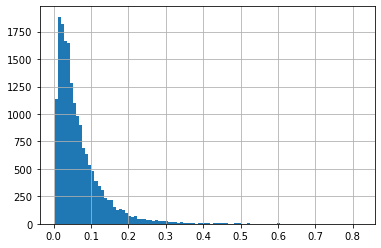

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
predictions.query("partition=='4'").query("split=='valid'").score_COX_clinical.hist(bins=100)

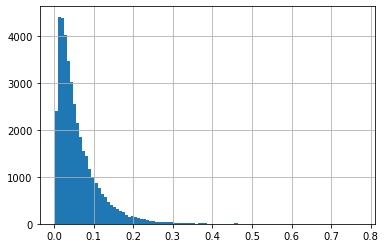

In [38]:
predictions.query("partition=='0'").query("split=='valid'").score_COX_MACE_clinical.hist(bins=100)

In [24]:
predictions.to_csv(f"{data_path}/3_datasets_post/{dataset_name}/predictions_coxph.csv", index=False)

In [85]:
predictions.tail()

,eid,score_COX_clinical,0_1_Ft_COX_clinical,0_2_Ft_COX_clinical,0_3_Ft_COX_clinical,0_4_Ft_COX_clinical,0_5_Ft_COX_clinical,0_6_Ft_COX_clinical,0_7_Ft_COX_clinical,0_8_Ft_COX_clinical,...,0_17_Ft_COX_clinical_pgs,0_18_Ft_COX_clinical_pgs,0_19_Ft_COX_clinical_pgs,0_20_Ft_COX_clinical_pgs,0_21_Ft_COX_clinical_pgs,0_22_Ft_COX_clinical_pgs,0_23_Ft_COX_clinical_pgs,0_24_Ft_COX_clinical_pgs,0_25_Ft_COX_clinical_pgs,0_26_Ft_COX_clinical_pgs
1978689,6025198,0.302564,0.021615,0.046786,0.075147,0.102025,0.130841,0.160260,0.189726,0.218453,...,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857
1978685,6025198,0.300681,0.021327,0.046941,0.074294,0.100906,0.129106,0.158781,0.188204,0.217251,...,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130
1978688,6025198,0.307658,0.022200,0.047657,0.075360,0.103045,0.132320,0.162574,0.192677,0.222838,...,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358
1978687,6025198,0.308601,0.022987,0.048860,0.076584,0.104698,0.133883,0.163955,0.193831,0.223485,...,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981
1978686,6025198,0.314298,0.023260,0.050451,0.079213,0.107872,0.137382,0.168453,0.199037,0.228170,...,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985


In [87]:
predictions[["eid", "score_COX_clinical", 'partition', 'split']]

,eid,score_COX_clinical,partition,split
0,1000018,0.058907,0,train
2,1000018,0.058406,1,test
3,1000018,0.058947,2,train
4,1000018,0.057233,3,train
1,1000018,0.058583,4,train
...,...,...,...,...
1978689,6025198,0.302564,0,valid
1978685,6025198,0.300681,1,test
1978688,6025198,0.307658,2,valid
1978687,6025198,0.308601,3,valid


In [18]:
predictions_df = pd.read_feather("/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/models/benchmarks/BEN-1285/predictions/predictions.feather")

In [19]:
predictions_df

,0_1_ft,0_1_Ft,0_1_St,0_2_ft,0_2_Ft,0_2_St,0_3_ft,0_3_Ft,0_3_St,0_4_ft,...,0_23_Ft_calibrated,0_24_Ft_calibrated,0_25_Ft_calibrated,0_26_Ft_calibrated,eid,split,partition,module,net,datamodule
0,0.030803,0.022290,0.977710,0.039299,0.057751,0.942249,0.044319,0.099765,0.900235,0.047347,...,0.139802,0.146783,0.153930,0.161087,1000018,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
1,0.048185,0.036345,0.963655,0.058220,0.090192,0.909808,0.062842,0.151037,0.848963,0.064484,...,0.249414,0.260941,0.272834,0.283636,1000020,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
2,0.053468,0.040084,0.959916,0.064656,0.099897,0.900103,0.069494,0.167342,0.832658,0.070809,...,0.308261,0.322440,0.337083,0.349919,1000043,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
3,0.039807,0.029643,0.970357,0.049027,0.074585,0.925415,0.053833,0.126272,0.873728,0.056177,...,0.189116,0.198088,0.207313,0.216100,1000079,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
4,0.028805,0.021258,0.978742,0.036251,0.054144,0.945856,0.040689,0.092789,0.907211,0.043434,...,0.114073,0.119544,0.125108,0.130846,1000084,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395733,0.018039,0.013417,0.986583,0.022897,0.034085,0.965915,0.026106,0.058681,0.941319,0.028405,...,0.048910,0.051133,0.053338,0.055936,6024701,test,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
395734,0.041583,0.030703,0.969297,0.051509,0.077817,0.922183,0.056635,0.132170,0.867830,0.059054,...,0.213297,0.223581,0.234180,0.244097,6024778,test,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
395735,0.027671,0.019840,0.980160,0.035789,0.051936,0.948064,0.040801,0.090415,0.909585,0.044011,...,0.124349,0.130700,0.137188,0.143797,6024787,test,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
395736,0.023525,0.017225,0.982775,0.029963,0.044256,0.955744,0.034002,0.076378,0.923622,0.036696,...,0.081644,0.085517,0.089424,0.093668,6024807,test,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212


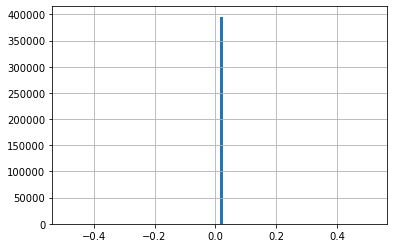

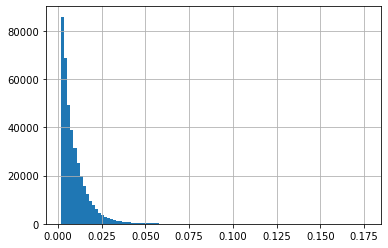

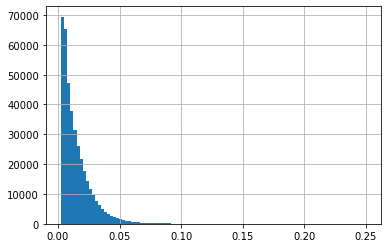

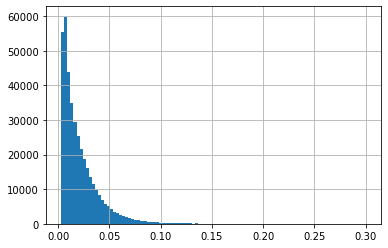

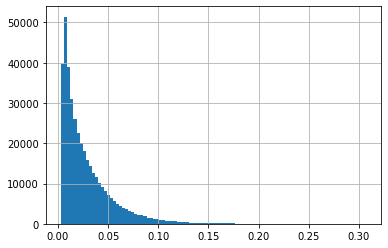

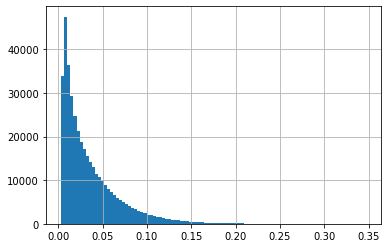

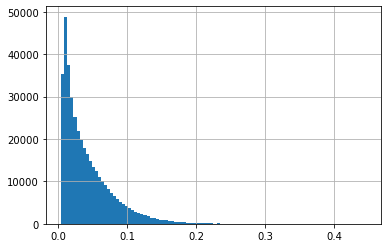

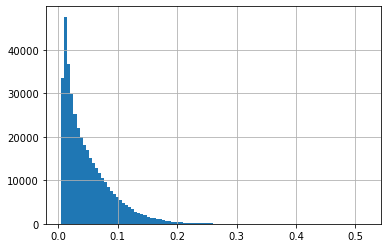

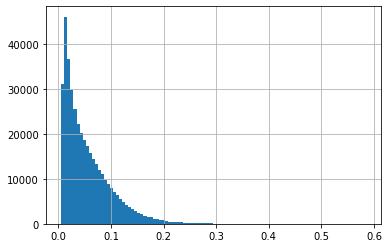

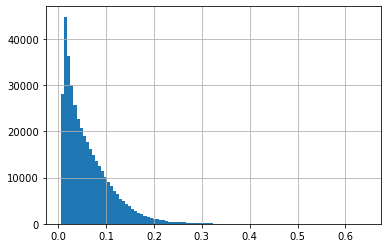

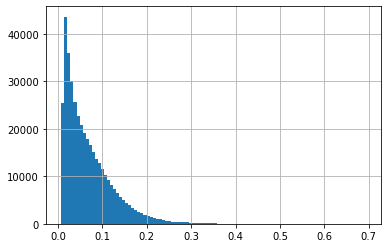

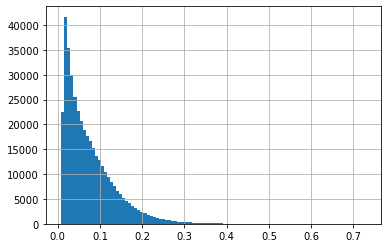

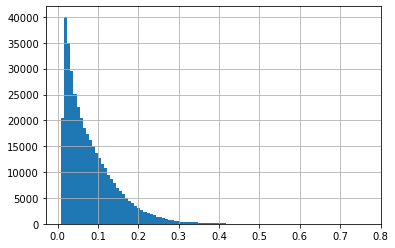

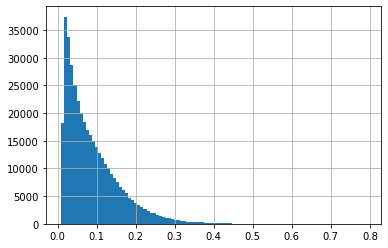

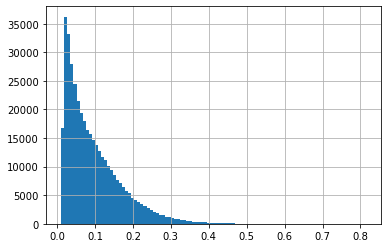

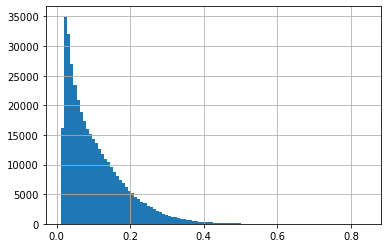

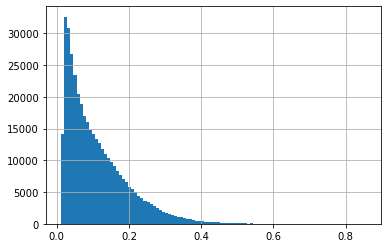

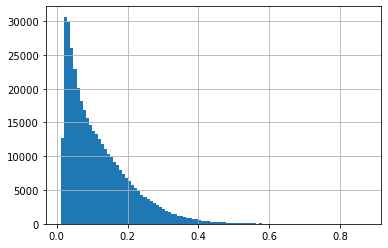

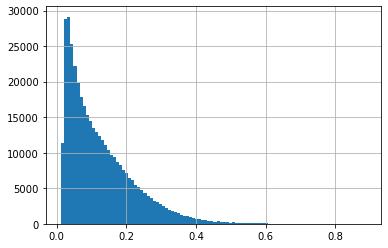

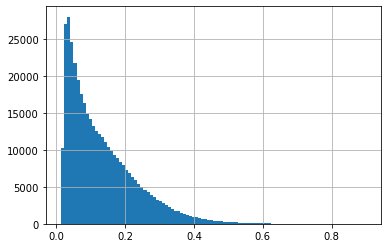

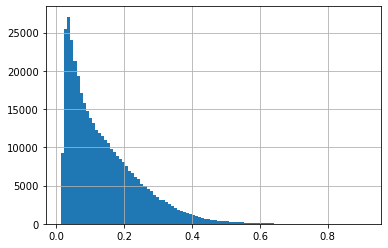

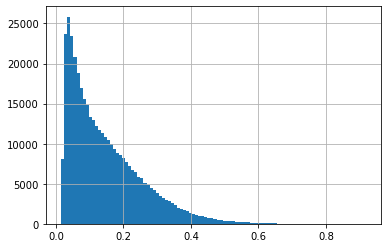

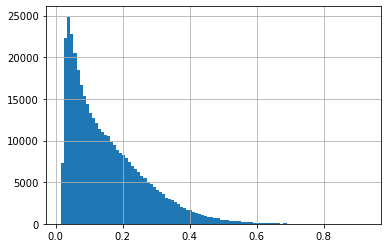

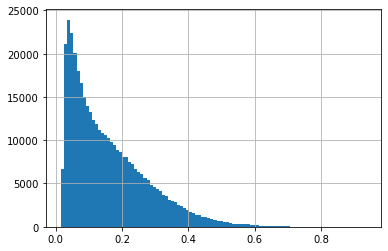

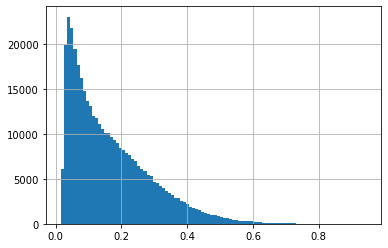

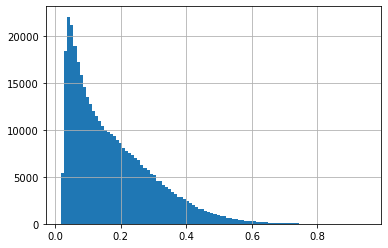

In [26]:
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)
for t in range(1, 27, 1):
    predictions_df[[col for col in predictions_df.columns.to_list() if f"_{t}_Ft" in col]+["partition", "split"]][f"0_{t}_Ft_calibrated"].hist(bins=100)
    plt.show()